In [1]:
import pandas as pd
import numpy as np
import numpy.typing as npt


from matplotlib import pyplot as plt
from tqdm import tqdm
from utility.types import RebalanceFrequencyEnum, AllocationMethodsEnum

from data.universe import Universe
from data.benchmark import Benchmark
from backtest.backtest import Backtester

In [2]:
universe = Universe.get_universe_returns()
universe

,MONTAIRE,ETF_GROWTH,ETF_VALUE,ETF_CAC,ETF_SPX
date,,,,,
2016-06-01,0.000000,0.000000,0.000000,0.000000,0.000000
2016-06-02,-0.000010,0.004860,0.004419,0.000442,0.003586
2016-06-03,0.000000,-0.010231,-0.005313,-0.009287,-0.017370
2016-06-06,-0.000020,-0.001316,0.014437,0.003236,0.005692
2016-06-07,0.000000,0.006586,0.005512,0.011012,0.005440
...,...,...,...,...,...
2024-02-22,0.000109,0.010694,0.004420,0.012323,0.020330
2024-02-23,0.000119,0.004429,0.000000,0.006920,0.004213
2024-02-26,0.000307,-0.003491,-0.004490,-0.004200,-0.004097


In [29]:
bench = Benchmark()
# universe = Universe.get_universe_returns()
# universe
benchmark = bench.get_benchmark_returns_data()
benchmark

,OISESTR,SPX,SX5T
Date,,,
2019-10-01,-0.000022,0.000000,0.000000
2019-10-02,-0.000022,-0.017903,-0.029827
2019-10-03,-0.000022,0.007972,0.001189
2019-10-04,-0.000022,0.014217,0.008586
2019-10-07,-0.000022,-0.004478,0.007117
...,...,...,...
2024-02-09,0.000155,0.000000,0.000000
2024-02-12,0.000155,0.004788,0.007551
2024-02-13,0.000155,-0.013674,-0.012024


In [106]:
from portfolio_management.market_regime import detect_market_regime


REGIMES = detect_market_regime(benchmark[["SPX"]].to_numpy())

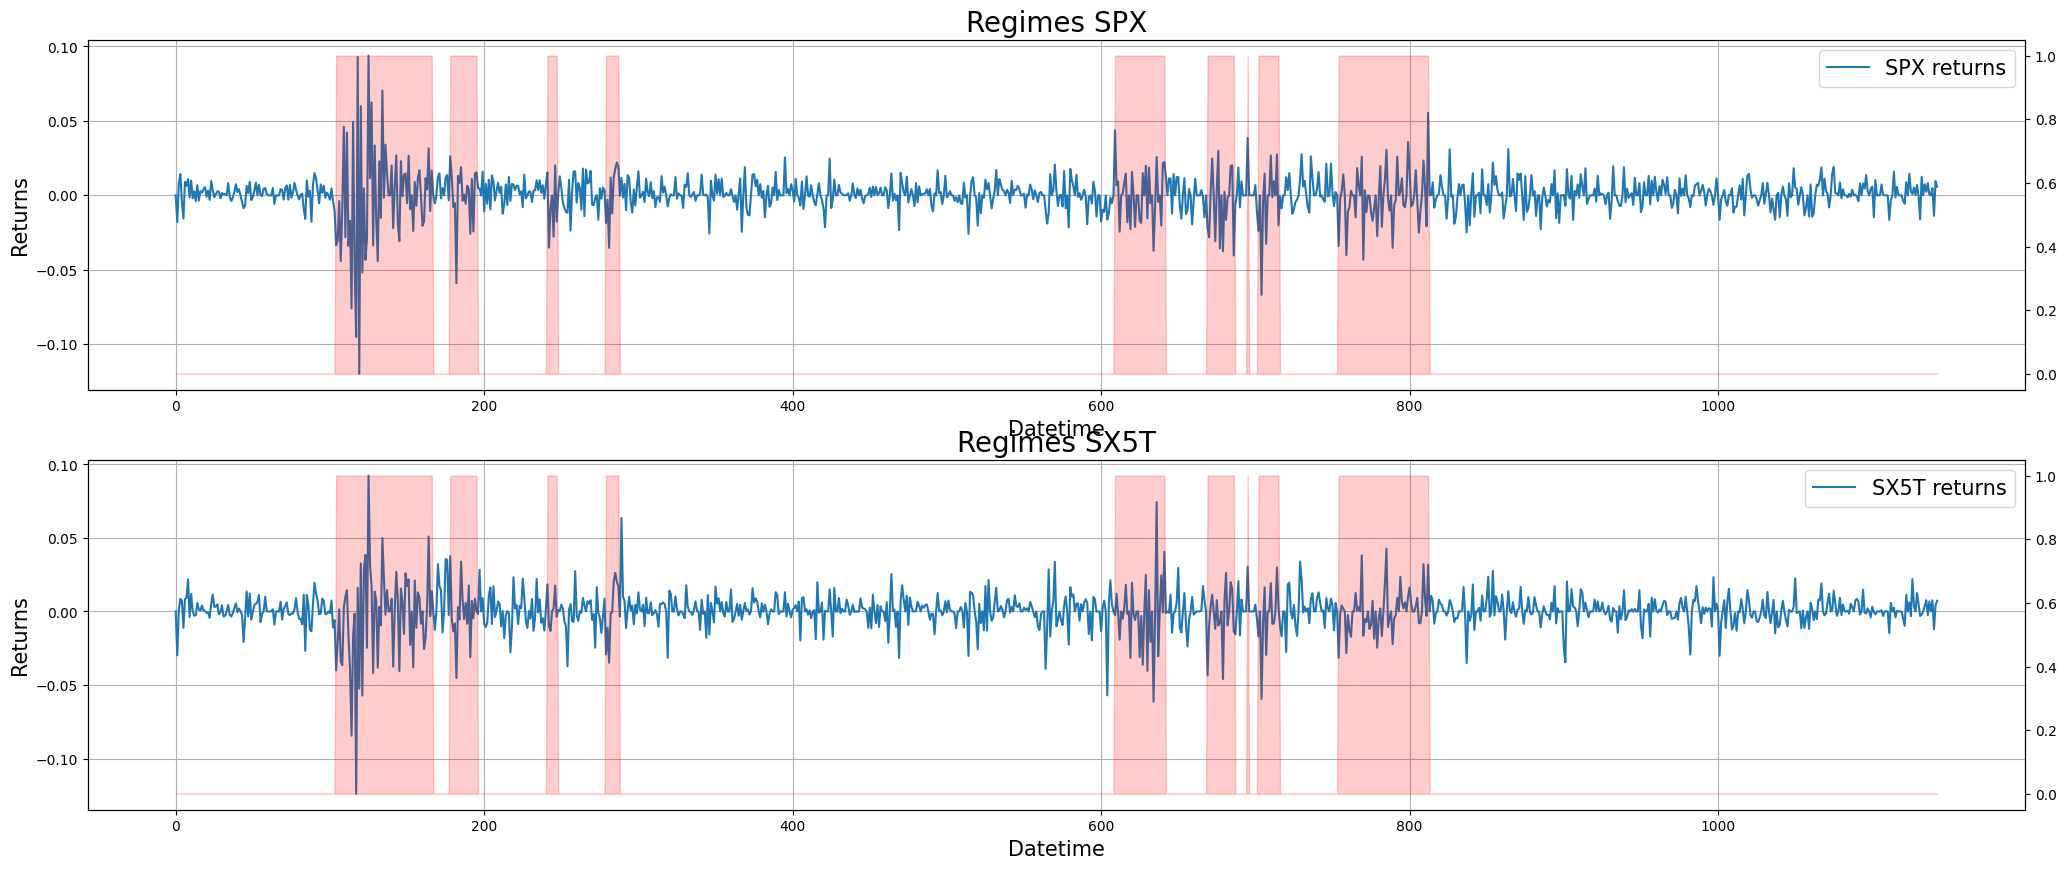

In [107]:
fig, ax = plt.subplots(2, 1, figsize=(25, 10))
ax_l = ax[0].twinx()
ax_l.fill_between(np.array(range(benchmark.SPX.shape[0])), REGIMES,alpha=0.2, color='red')
ax[0].plot(np.array(range(benchmark.SPX.shape[0])), benchmark.SPX, label="SPX returns")
ax[0].set_xlabel("Datetime", fontsize=15)
ax[0].set_ylabel("Returns", fontsize=15)
ax[0].set_title("Regimes SPX", fontsize=20)
ax[0].grid()
ax[0].legend(fontsize=15)

ax_l = ax[1].twinx()
ax_l.fill_between(np.array(range(benchmark.SX5T.shape[0])), REGIMES,alpha=0.2, color='red')
ax[1].plot(np.array(range(benchmark.SX5T.shape[0])), benchmark.SX5T, label="SX5T returns")
ax[1].set_xlabel("Datetime", fontsize=15)
ax[1].set_ylabel("Returns", fontsize=15)
ax[1].set_title("Regimes SX5T", fontsize=20)
ax[1].grid()
ax[1].legend(fontsize=15)

In [ ]:
WITH_MEMORY = True
FIRST_TRAINED = False
STARTING_OFFSET = 500
EVERY = 300
VERBOSE = False
market["Regime_switch"] = 0
tot = STARTING_OFFSET


for row in tqdm(
    market.iloc[STARTING_OFFSET:].itertuples(index=True),
    desc="Training",
    total=market.iloc[STARTING_OFFSET:].shape[0],
    leave=False,
):
    data = market.loc[: row.Index]["EMA"].dropna()
    data_scaled = StandardScaler().fit_transform(data.to_numpy().reshape(-1, 1))
    if FIRST_TRAINED is False or tot % EVERY == 0:
        if VERBOSE is True:
            print(f"Retraining with data from {data.index[0]} to {data.index[-1]}")
        FIRST_TRAINED = True
        try:
            del model
        except:
            pass

        model = GaussianHMM(
            n_components=2, covariance_type="full", random_state=42, n_iter=100
        )
        model.fit(data_scaled)
    predicted = normalize_regime(model.predict(data_scaled))
    market.loc[row.Index, "Regime_switch"] = predicted[-1]
    tot += 1

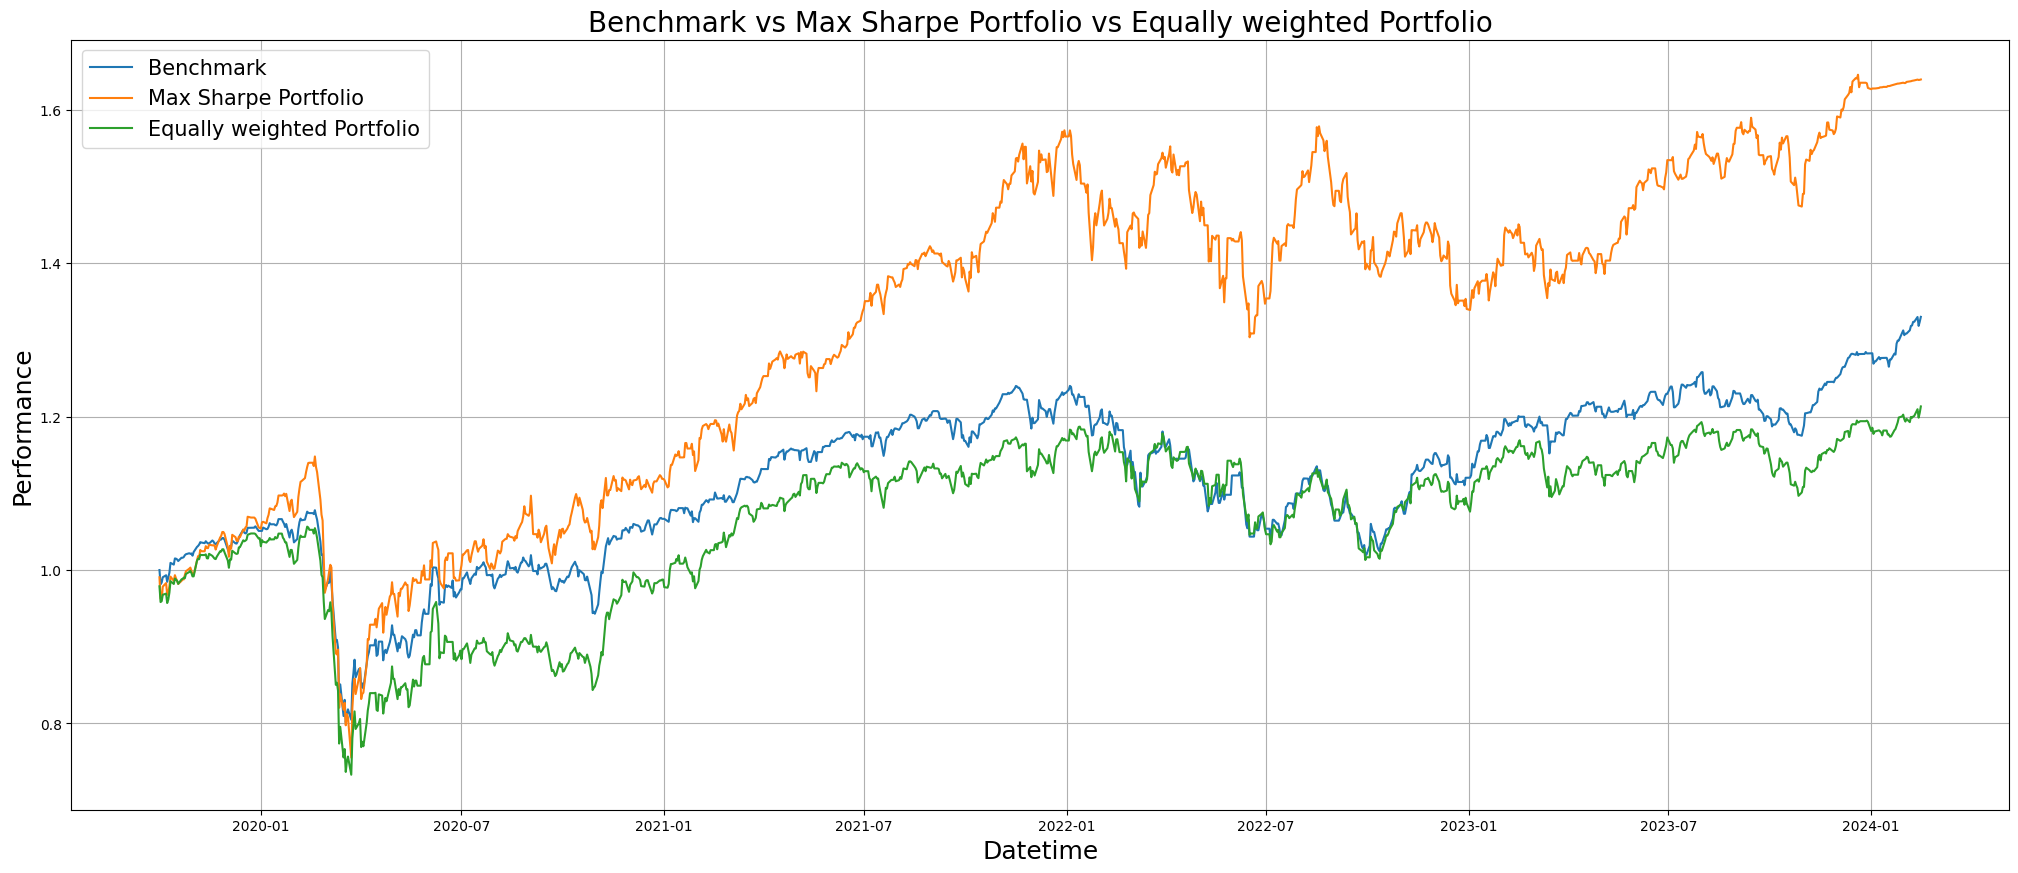

In [40]:
plt.figure(figsize=(25, 10))
plt.plot(ptf_and_bench_perf["benchmark_returns"], label="Benchmark")
plt.plot(ptf_and_bench_perf["ptf_returns_max_sharpe"], label="Max Sharpe Portfolio")
plt.plot(
    ptf_and_bench_perf["ptf_returns_equal_weight"], label="Equally weighted Portfolio"
)
plt.xlabel("Datetime", fontsize=18)
plt.ylabel("Performance", fontsize=18)
plt.title(
    "Benchmark vs Max Sharpe Portfolio vs Equally weighted Portfolio",
    fontsize=20,
)
plt.grid()
plt.legend(fontsize=15)

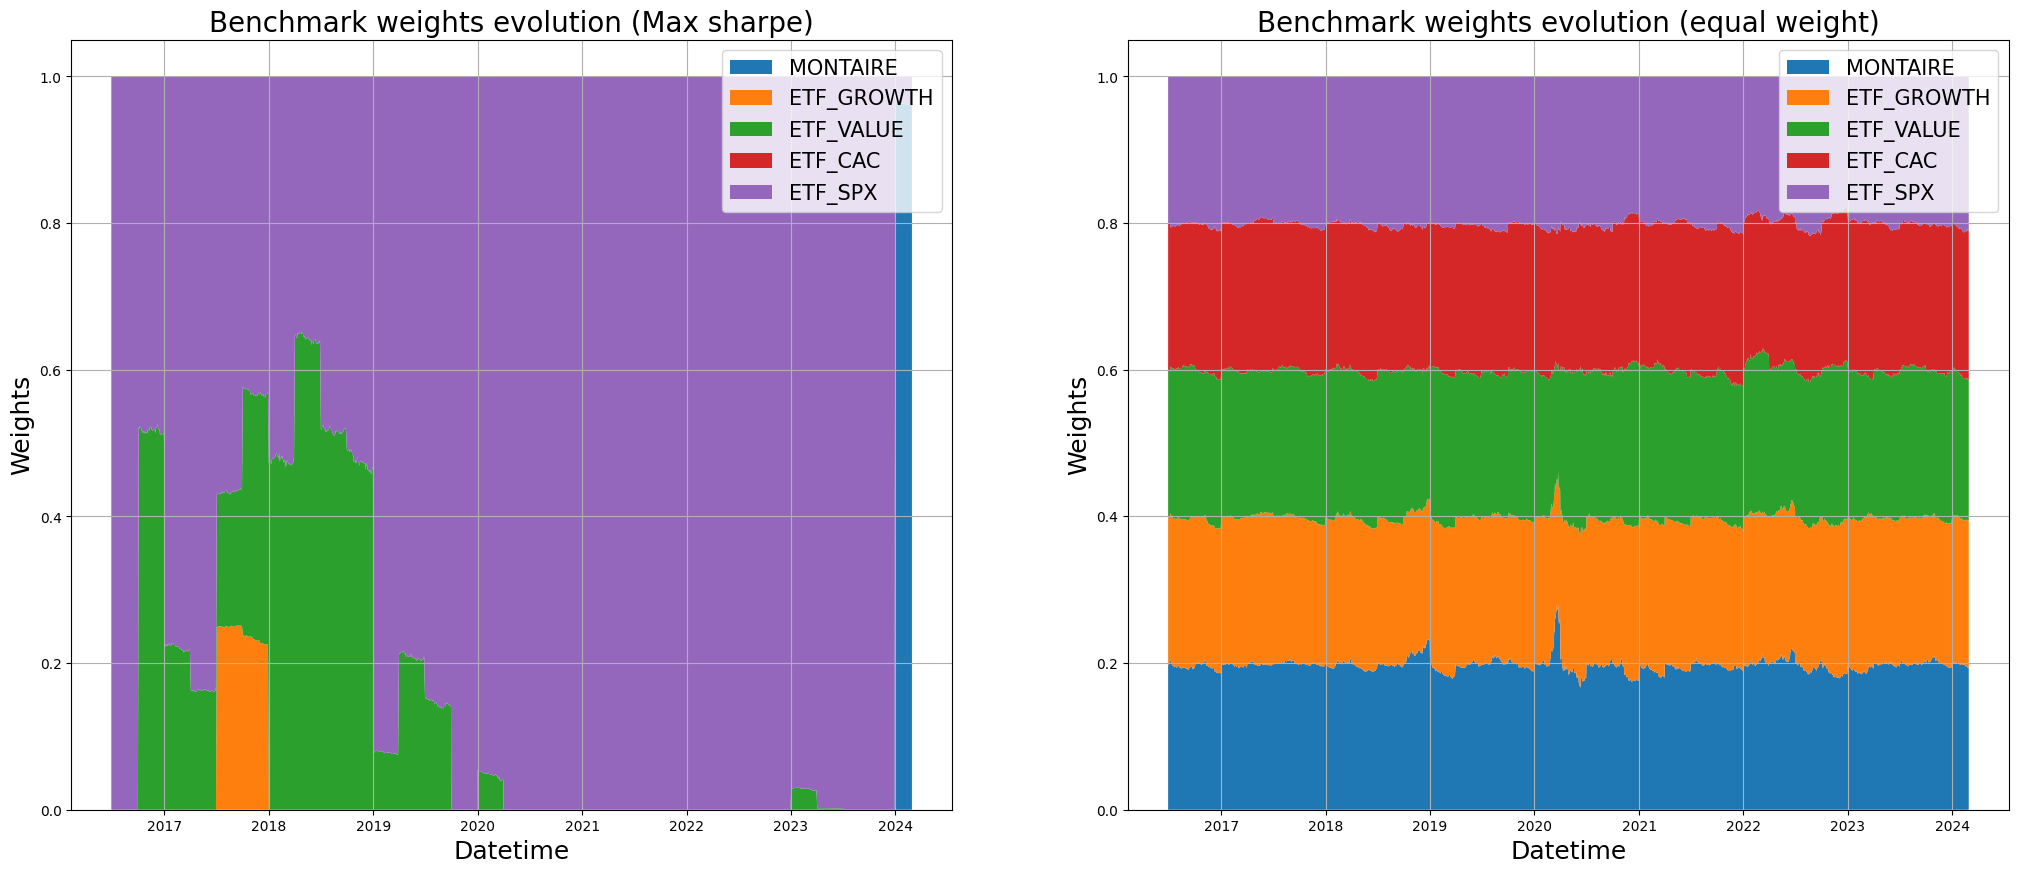

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(25, 10))

ax[0].stackplot(
    ptf_weights_max_sharpe.index,
    ptf_weights_max_sharpe.to_numpy().T,
)
ax[0].set_xlabel("Datetime", fontsize=18)
ax[0].set_ylabel("Weights", fontsize=18)
ax[0].set_title("Benchmark weights evolution (Max sharpe)", fontsize=20)
ax[0].grid()
ax[0].legend(ptf_weights_max_sharpe.columns.to_list(), fontsize=15)


ax[1].stackplot(
    ptf_weights_equal_weight.index,
    ptf_weights_equal_weight.to_numpy().T,
)
ax[1].set_xlabel("Datetime", fontsize=18)
ax[1].set_ylabel("Weights", fontsize=18)
ax[1].set_title("Benchmark weights evolution (equal weight)", fontsize=20)
ax[1].grid()
ax[1].legend(ptf_weights_equal_weight.columns.to_list(), fontsize=15)